## ml-mipt course

### Seminar 2: extra materials
### Linear Regression Loss functions and Probability interpretation

Based on [Evgeny Sokolov](https://github.com/esokolov) open materials.

## Данные
Для демонстраций загрузим набор данных [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/Automobile). В данных присутствуют категориальные, целочисленные и вещественнозначные признаки.

In [265]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression as LR


X_raw = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)

In [202]:
X_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [203]:
y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

## Предобработка данных
Предобработка данных важна при применении любых методов машинного обучения, а в особенности для линейных моделей. В sklearn предобработку удобно делать с помощью модуля [preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) или методов библиотеки pandas.

### Заполнение пропусков
В матрице объекты-признаки могут быть пропущенные значения, и это вызовет исключение при попытке передать такую матрицу в функцию обучения модели или даже предобработки. Если пропусков немного, можно удалить объекты с пропусками из обучающей выборки. Заполнить пропуски можно разными способами:
* заполнить средними (mean, median);
* предсказывать пропущенные значения по непропущенным.

Последний вариант сложный и применяется редко. Для заполнения константами можно использовать метод датафрейма fillna, для замены средними - класс preprocessing.Imputer.

In [204]:
# для удобства работы с нашим датасетом создаем маску, указывающую на столбцы с категориальными признаками
cat_features_mask = (X_raw.dtypes == "object").values  # категориальные признаки имеют тип "object"

In [205]:
# для вещественнозначных признаков заполним пропуски средними
X_real = X_raw[X_raw.columns[~cat_features_mask]]
mis_replacer = SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(data=mis_replacer.fit_transform(X_real), columns=X_real.columns)
# для категориальных - пустыми строками
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("")
X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)

In [206]:
X_no_mis.head()

,0,1,9,10,11,12,13,16,18,19,...,2,3,4,5,6,7,8,14,15,17
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,alfa-romero,gas,std,two,convertible,rwd,front,dohc,four,mpfi
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,alfa-romero,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,audi,gas,std,four,sedan,fwd,front,ohc,four,mpfi
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,audi,gas,std,four,sedan,4wd,front,ohc,five,mpfi


Всегда нужно осознавать, случайны ли пропуски в каком-то признаке. Иногда факт отсутствия информации о значении признака может сам быть важным признаком, который необходимо добавить к другим признакам.

__Пример:__ предсказание возраста пользователя по данным с его телефона. Поскольку люди старшего возраста чаще пользуются простыми телефонами, факт отсутствия каких-то данных (например, истории посещенных интернет-страниц), скорее всего, будет хорошим признаком.

Для категориальных признаков рекомендуется создавать отдельную категорию, соответствующую пропущенному значению. В наши данных пропусков в категориальных признаках нет.

### Преобразование нечисловых признаков
Практически все методы машинного обучения требуют, чтобы на вход функции обучения подавалась вещественная матрица. В процессе обучения используются свойства вещественных чисел, в частности, возможность сравнения и применения арифметических операций. Поэтому, даже если формально в матрице объекты-признаки записаны числовые значения, нужно всегда анализировать, можно ли относиться к ним как к числам. 

__Пример:__ некоторые признаки могут задаваться целочисленными хешами или id (например, id пользователя соц. сети), однако нельзя сложить двух пользователей и получить третьего, исходя из их id (как это может сделать линейная модель).

Это пример категориального признака, принимающего значения из неупорядоченного конечного множества $K$. К таким признакам обычно применяют [one-hot encoding](http://scikit-learn.org/stable/modules/preprocessing.html#encoding-categorical-features) (вместо одного признака создают $K$ бинарных признаков - по одному на каждое возможное значение исходного признака). В sklearn это можно сделать с помощью классов LabelEncoder + OneHotEncoding, но проще использовать функцию pd.get_dummies.

Следует заметить, что в новой матрице будет очень много нулевых значений. Чтобы не хранить их в памяти, можно задать параметр OneHotEncoder(sparse = True) или .get_dummies(sparse=True), и метод вернет [разреженную матрицу](http://docs.scipy.org/doc/scipy/reference/sparse.html), в которой хранятся только ненулевые значения. Выполнение некоторых операций с такой матрицей может быть неэффективным, однако большинство методов sklearn умеют работать с разреженными матрицами.

__Вопрос:__ какая проблема возникнет при применении такого способа кодирования для обучения линейной регрессии?
    
Необходимо удалить один из столбцов, созданных для каждого признака. Для этого в get_dummies надо поставить drop_first=True.

In [207]:
X_no_mis.shape

(205, 25)

In [208]:
X_dum = pd.get_dummies(X_no_mis, drop_first=True)
print(X_dum.shape)
X_dum.head()

(205, 66)


,0,1,9,10,11,12,13,16,18,19,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,0,0,0,0,0,0,0,1,0,0
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0


Помимо категориальных, преобразования требуют, например, строковые признаки. Их можно превращать в матрицу частот слов [CountVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer), матрицу частот буквосочетаний фиксированной длины, можно извлекать другие признаки (например, длина строки).

### Масштабирование признаков
При начале работы с данными всегда рекомендуется приводить все признаки к одному масштабу.  Это важно по нескольким причинам:
* ускорение обучения модели (пояснение на лекции);
* улучшение численной устойчивости при работе с матрицей объекты-признаки (рядом с нулем чисел с плавающей точкой больше, чем с области больших чисел)
* для линейных моделей: интерпретация весов при признаках как меры их значимости.

Первый популярный способ масштабирования - нормализация: вычитание среднего из каждого признака и деление на стандартное отклонение (StandardScaler в sklearn). Второй популярный способ: вычитание минимума из каждого признака, а затем деление на разницу максимального и минимального значения (MinMaxScaler в sklearn).

In [209]:
normalizer = preprocessing.MinMaxScaler()
X_real_norm_np = normalizer.fit_transform(X_dum)
X = pd.DataFrame(data=X_real_norm_np, dtype="float64")

In [210]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,1.0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.6,0.298429,0.230321,0.449254,0.433333,0.383333,0.517843,0.343396,0.100000,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.8,0.518325,0.384840,0.529851,0.491667,0.541667,0.329325,0.181132,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.8,0.518325,0.373178,0.529851,0.508333,0.541667,0.518231,0.283019,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Добавление признаков
Особенно важным моментом для линейной регрессии является нелинейное преобразование признаков. Это позволяет использовать линейную регрессию для моделирования нелинейных зависимостей. Наиболее популярны следующие преобразования: полиномиальные признаки (PolynomialFeatures в sklearn), взятие логарифма, квадратного корня, применение тригонометрических функий.

Например, в нашем датасете зависимость целевой перемнной от шестого признака скорее квадратичная, чем линейная:

In [211]:
%matplotlib inline

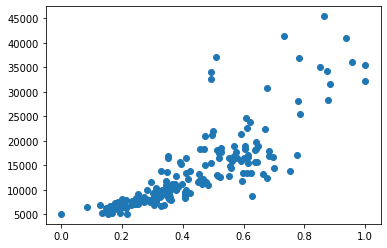

In [212]:
plt.scatter(X[6], y)

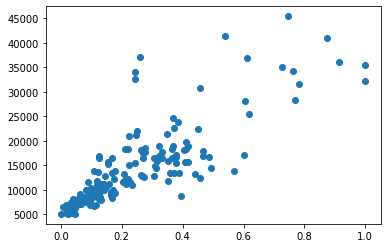

In [213]:
plt.scatter(X[6] ** 2, y)

А для признака номер 13 линеаризовать зависимость получается с помощью функции $\frac 1 {\sqrt{\cdot}}$

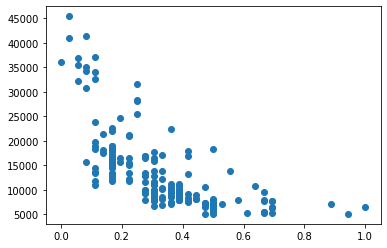

In [214]:
plt.scatter(X[13], y)

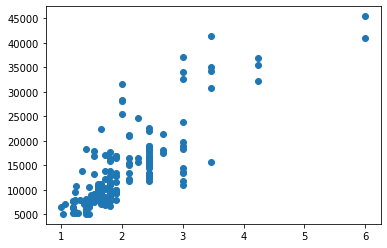

In [215]:
plt.scatter(1 / np.sqrt(X[13]), y)

Обратите внимание, что при генерации полиномиальных признаков матрица объекты-признаки может занимать очень много памяти. Генерация полиномиальных признаков нужна, например, в случае, если вы хотите с помощью линейной регрессии настраивать полиномиальную модель зависимости целевого признака от данных.

In [216]:
X.to_json('data_preprocessed.json')

## Функции потерь в регрессии

Функционал качества в задачах обучения с учителем обычно задается в виде суммы по объектам выборки:
$$Q(a) = \frac 1 \ell \sum_{i=1}^\ell L(y_i, a(x_i)),$$
где $L(\cdot, \cdot)$ - функция потерь, задающая штраф за разницу между предсказанием и истинным значением целевого признака. Свойства функции потерь:
* $L(y_i, a(x_i)) \geqslant 0$;
* $L(y_i, y_i) = 0$. 

Как отмечалось на первой лекции, функционал качества должен в первую очередь отвечать требованиям заказчика, при этом математические свойства функции потерь могут быть неудобны для оптимизации. 

__Пример:__ если мы не различаем маленькие ошибки (между 0.01 и 0.1 нет особой разницы), но зато не хотим получать большие ошибки, можно использовать следующую функцию потерь:

$$L(y_i, a(x_i)) = [| y_i - a(x_i) | < \varepsilon],$$ $\varepsilon$ - допустимая разница между предсказанием и фактом.


### Среднеквадратичная и средняя абсолютная ошибка
Кроме требований заказчика, функционал качества должен учитывать математические особенности модели, например устойчивость к шумовым объектам. В линейной регрессии Mean Squared Error: $L(y_i, a(x_i)) = (a(x_i) - y_i)^2$ не обладает этим свойством, потому что задает очень большие штрафы за большие отклонения от фактического значения. 

Рассмотрим это явление на примере. Выберем один признак, от которого целевой признак (имеющий индекс 15 в матрице X) зависит практически линейно. Добавим к выборке два объекта-выброса и посмотрим, как изменится оптимизированная на MSE прямая.

In [217]:
%matplotlib inline

In [218]:
X_subset = X[[7, 15]].values
X_subset_modified = np.vstack((X_subset, [[1, 90], [2, 50]]))  # добавление двух шумовых точек

In [219]:
def scatter_points_and_plot_line_MSE(X_subset):
    plt.scatter(X_subset[:, 0], X_subset[:, 1])  # визуализируем точки
    lr = LR()
    lr.fit(X_subset[:, 0][:, np.newaxis], X_subset[:, 1])  # найдем веса линейной модели
    grid = np.linspace(0, 2, 100)
    line = lr.predict(grid[:, np.newaxis])
    plt.plot(grid, line)  # визуализируем прямую

Text(0.5, 0, 'x')

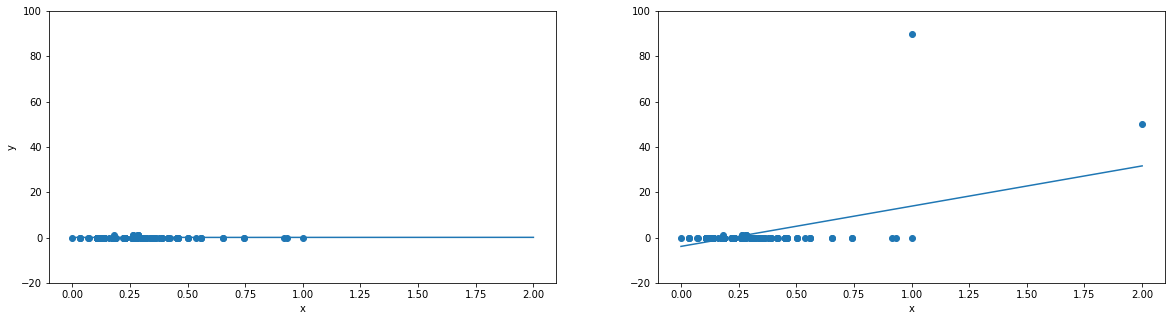

In [220]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
scatter_points_and_plot_line_MSE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
scatter_points_and_plot_line_MSE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlabel("x")

Из-за шумовых объектов прямая достаточно сильно изменила наклон. Поэтому вместо MSE часто используют Mean Absoulte Error: $L(y_i, a(x_i)) = |a(x_i) - y_i|$:

Теперь обучим регрессию, оптимизируя MAE. В sklearn такая регрессия не реализована, но можно использовать модуль statsmodels

In [221]:
def scatter_points_and_plot_line_MAE(X_subset):
    mod = smf.quantreg(
        'f15 ~ f7', pd.DataFrame(data=X_subset, columns=["f7", "f15"])
    )  # задаеем зависимость и передаем данные
    res = mod.fit(q=0.5)
    plt.scatter(X_subset[:, 0], X_subset[:, 1])  # визуализируем точки
    grid = np.linspace(0, 2, 100)
    plt.plot(grid, grid * res.params["f7"] + res.params["Intercept"])  # визуализируем прямую
    return mod, res

/home/karen-1999/anaconda3/envs/ml-mipt/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/home/karen-1999/anaconda3/envs/ml-mipt/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:207: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/home/karen-1999/anaconda3/envs/ml-mipt/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:218: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0


Text(0.5, 0, 'x')

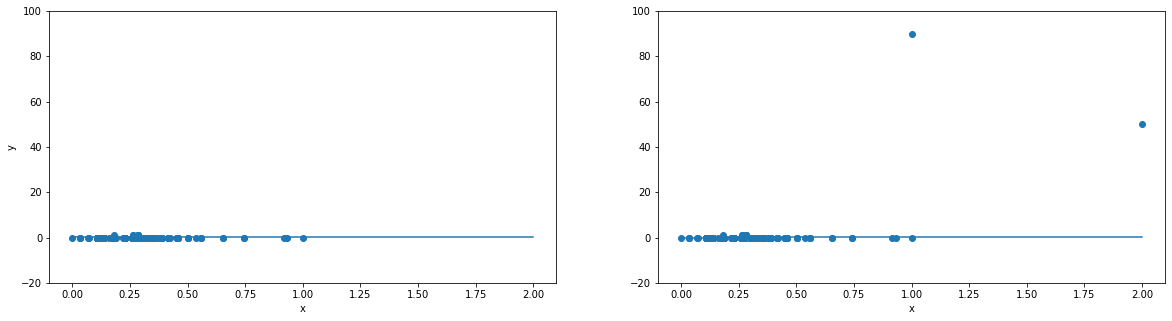

In [222]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model, result = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
model, result = scatter_points_and_plot_line_MAE(X_subset_modified)
plt.ylim(-20, 100)
plt.xlabel("x")

Прямая не изменила направление из-за выбросов.

Попробуем добавить больше шумовых объектов:

In [223]:
X_subset_modified_twice = np.vstack(
    (X_subset_modified, np.random.randint(5, size=60).reshape(-1, 2) * [1, 30])
)  # добавление двух шумовых точек

/home/karen-1999/anaconda3/envs/ml-mipt/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:205: RuntimeWarning: divide by zero encountered in double_scalars
  d = np.where(e > 0, (q/fhat0)**2, ((1-q)/fhat0)**2)
/home/karen-1999/anaconda3/envs/ml-mipt/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:207: RuntimeWarning: invalid value encountered in multiply
  xtdx = np.dot(exog.T * d[np.newaxis, :], exog)
/home/karen-1999/anaconda3/envs/ml-mipt/lib/python3.8/site-packages/statsmodels/regression/quantile_regression.py:218: RuntimeWarning: divide by zero encountered in double_scalars
  lfit.sparsity = 1. / fhat0


Text(0.5, 0, 'x')

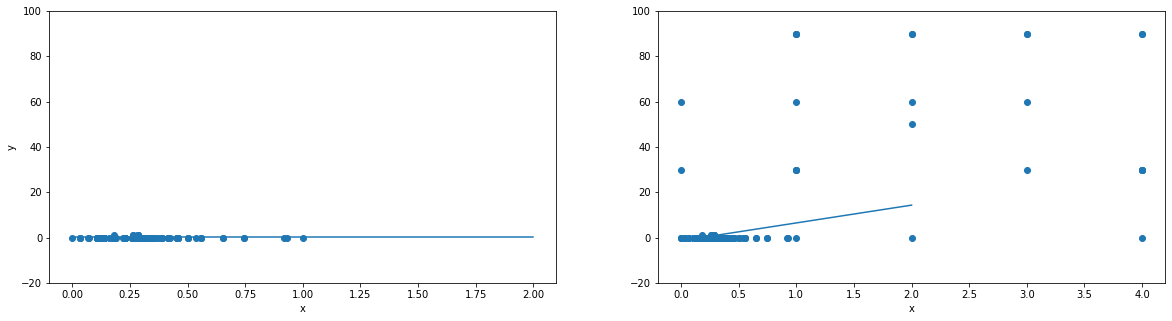

In [224]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
model, result = scatter_points_and_plot_line_MAE(X_subset)
plt.ylim(-20, 100)
plt.xlabel("x")
plt.ylabel("y")
plt.subplot(1, 2, 2)
model, result = scatter_points_and_plot_line_MAE(X_subset_modified_twice)
plt.ylim(-20, 100)
plt.xlabel("x")

Прямая изменила наклон, когда мы добавили 30 (почти 15%) шумовых точек.

Рассмотрим некоторые свойства MSE и MAE.

Пусть алгоритм возвращает константный ответ: $a(x) = C$. Такие алгоритмы используются, когда нужно по истории значений целевого признака предсказать его новое значение (например, сумму покупок в супермаркете).

__Задача.__ Найдите $C$, минимизирующий среднеквадратичную ошибку.

_Решение._ $$MSE(C) = \sum_{i=1}^\ell (C - y_i)^2$$
$$\frac{\partial MSE (C)}{\partial C} = \sum_{i=1}^\ell 2 (C - y_i) = 2 C \ell - \sum_{i=1}^\ell 2 y_i = 0$$
$$C = \frac 1 \ell \sum_{i=1}^\ell y_i$$.

__Задача.__ Найдите $C$, минимизирующий среднюю абсолютную ошибку.

_Решение._ $$MAE(C) =  \sum_{i=1}^\ell |C - y_i|$$

Покажем, что минимум MAE достигается при $C = median(y_1, \dots, y_\ell) = m.$ Рассмотрим $C < m$.

$$|y_i - C| - |y_i - m| = \begin{cases} C - m, y_i < С  \\ -C - m + 2 y_i, C \leqslant y_i \leqslant m \\ - (C - m), y_i > m \end{cases}$$
$$|y_i - C| - |y_i - m| \geqslant - (C - m) + 2(C - m) [y_i \leqslant m]$$
Суммируем по i:
$$\ell MAE(C) - \ell MAE(m) \geqslant - \ell (C - m) + 2 (C - m) \sum_{i=1}^\ell [y_i \leqslant m]$$

Так как m - медиана, $\sum_{i=1}^\ell [y_i \leqslant m] \geqslant \frac \ell 2$. Тогда

$$\ell MAE(C) - \ell MAE(m) \geqslant - \ell (C - m) + 2 (C - m) \frac \ell 2 = 0.$$

Итак, для $C < m$ $MAE(C) \geqslant MAE(m)$. Аналогично показывается, что при для $C > m$ $MAE(C) \geqslant MAE(m)$.

Поскольку средняя абсолютная ошибка не является дифференцируемой по $w$ функцией, оптимизировать ее напрямую методом градиентного спуска не удастся. Для этого используются субградиентные или другие методы.

### Huber Loss
Иногда используют "гибрид" MAE и MSE, который, как и MAE, устойчив к шумовым объектам, и как и MSE, мало штрафует малые отклонения от фактического значени целевого признака - Huber Loss:
$$L(y_i, a(x_i)) = \phi_\varepsilon(a(x_i) - y_i)$$
$$\phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}$$

Легко проверить, что у этой функции существует непрерывная первая проиводная во всех точках.

Оптимизация Huber Loss реализована в sklearn:

### Quantile Loss

В некоторых задачах штраф за ошибку зависит не только от величины абсолютного отклонения от фактического значения, но и от знака этого отклонения. Например, лучше предсказать спрос больше, чем будет по факту, чем меньше, потому что в первом случае будет потеряна прибыль. В этом случае используется квантильная регрессия со следующей функцией потерь:
$$L(y_i, a(x_i)) = \rho_\tau(y_i - x_i^T w),$$
$$\rho_\tau(z) = \begin{cases} \tau z, \quad z > 0, \\ (\tau - 1) z, \quad z \leqslant 0 \end{cases}$$
Параметр $\tau$ влияет на то, насколько различаются штрафы за положительную и отрицательную разницу.

Изобразим график квантильной функции потерь вместе с другими рассмотренными:

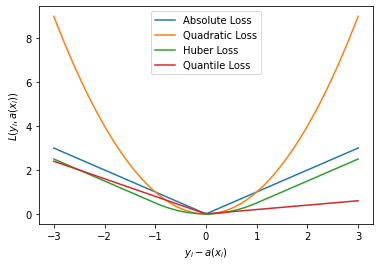

In [225]:
grid = np.linspace(-3, 3, 100)
quantile_tau = 0.2
mse_loss = grid ** 2
mae_loss = np.abs(grid)
huber_loss = (
    0.5 * mse_loss * (grid >= -1) * (grid <= 1)
    + (mae_loss - 0.5) * (grid < -1)
    + (mae_loss - 0.5) * (grid > 1)
)
quantile_loss = quantile_tau * grid * (grid > 0) + (quantile_tau - 1) * grid * (grid <= 0)
plt.plot(grid, mae_loss, label="Absolute Loss")
plt.plot(grid, mse_loss, label="Quadratic Loss")
plt.plot(grid, huber_loss, label="Huber Loss")
plt.plot(grid, quantile_loss, label="Quantile Loss")
plt.xlabel("$y_i - a(x_i)$")
plt.ylabel("$L(y_i, a(x_i))$")
plt.legend()

__Задача.__ Укажите параметр $\tau$, при котором обучение квантильной регрессии равносильно оптимизации MAE.

_Решение._ При $\tau = \frac 1 2$ $$\rho_\tau(x) = \frac 1 2 |x|$$ и $L(y_i, a(x_i)) = \frac 1 2 MAE$.

Проследим наклон прямой в нашей одномерной задаче регрессии при изменении $\tau$:

Text(0, 0.5, 'y')

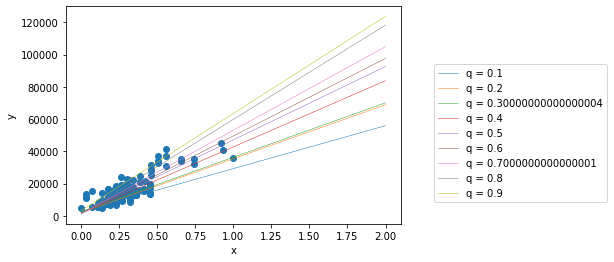

In [226]:
plt.scatter(X[7], y)
grid = np.linspace(0, 2, 100)
dat = pd.DataFrame({"x": X[7], "y": y})
mod = smf.quantreg('y ~ x', dat)
for q in np.arange(0.1, 1, 0.1):
    res = mod.fit(q=q)
    plt.plot(
        grid, grid * res.params["x"] + res.params["Intercept"], linewidth=0.5, label="q = " + str(q)
    )
plt.legend(loc=(1.1, 0.1))
plt.xlabel("x")
plt.ylabel("y")

### Multicollinearity

In case of multicollinear (or highly correlated) features presence the vanilla linear models tends to suffer.

In [227]:
def visualise(mu, sigma, points, x_ticklabels=None, title=None, greater_than_zero=False):
    if greater_than_zero:
        mu = np.clip(mu, 0, mu.max())

    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    plt.plot(points, mu, "r", label="mean value")
    _x = np.concatenate((points, points[::-1]))
    _y = np.concatenate(
        (
            [mu[i] - sigma[i] for i in range(len(points))],
            [mu[i] + sigma[i] for i in range(len(points) - 1, -1, -1)],
        )
    )
    if greater_than_zero:
        _y = np.clip(_y, 0.0, _y.max())
    plt.fill(_x, _y, fc='r', alpha=0.2, ec=None, label='+- sigma range')

    if x_ticklabels is not None:
        ax.set_xticks(np.arange(len(x_ticklabels)))
        ax.set_xticklabels(x_ticklabels)

    if title is not None:
        plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.grid()

Let's generate new dataset with correlated features:

In [249]:
n_features = 3
n_objects = 300
batch_size = 10
num_steps = 43
eps = 1e-3

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  # for different scales
X[:, -1] = X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape)
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_0 = np.random.uniform(-2, 2, (n_features))

In [250]:
w_true

array([ 0.70347655, -0.92609024, -1.01717852])

In [251]:
w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
w_star

array([  0.68217219,  38.44931702, -40.390858  ])

As we can see, the second and third coefficents are opposite. This makes our model highly *unstable*.

Same case with the gradient descent method:

In [252]:
w = w_0.copy()
w_list = [w.copy()]
step_size = 1e-3

for i in range(num_steps):
    w -= 2 * step_size * np.dot(X.T, np.dot(X, w) - Y) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)

w_list[-1]

array([ 0.22749894, -2.72745826,  0.77977551])

And stochastic gradient:

In [253]:
w = w_0.copy()
w_list = [w.copy()]
step_size = 0.2

for i in range(num_steps):
    sample = np.random.randint(n_objects, size=batch_size)
    w -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / Y.shape[0]
    w_list.append(w.copy())
w_list = np.array(w_list)
w_list[-1]

array([ 0.56773382, -2.10359515,  1.40390529])

However, regularization can fix it:

In [254]:
w_star = np.linalg.inv(X.T.dot(X) + 0.05 * np.eye(n_features)).dot(X.T).dot(Y)
w_star

array([ 0.68264238, -0.9300162 , -1.01164745])

The solution is *unstable*. Let's take a look at the *condition number* of our matrix:
$$\kappa(a) = \frac{\sigma_\max(A)}{\sigma_\min(A)}$$
where $\sigma _{\max }(A)$ and $\sigma _{\min }(A)$ are maximal and minimal singular values of $A$ respectively. Hence

In [255]:
def get_w_by_grad(X, Y, num_steps, w_0, step_size):
    w = w_0.copy()

    for i in range(num_steps):
        w -= 2 * step_size * np.dot(X.T, np.dot(X, w) - Y) / Y.shape[0]
    return w


def get_w_by_stoch_grad(X, Y, num_steps, w_0, step_size_0, n_objects):
    w = w_0.copy()
    step_size_0 = 0.45

    for i in range(num_steps):
        step_size = step_size_0 / ((i + 1) ** 0.51)
        sample = np.random.randint(n_objects, size=batch_size)
        w -= 2 * step_size * np.dot(X[sample].T, np.dot(X[sample], w) - Y[sample]) / Y.shape[0]
    return w


def rmse(y_true, y_pred):
    return np.linalg.norm(y_true - y_pred)

In [256]:
step_size = 1e-3
sgd_step_size = 0.1
num_steps = 250
noise_eps_seq = np.linspace(1e-2, 7e-7, 20)

In [257]:
condition_numbers = []
vector_norms_list = []
rmse_list = []
results_list = []
for eps in noise_eps_seq:
    local_condition_numbers = []
    local_vector_norms_list = []
    local_rmse_list = []
    for i in range(50):
        X[:, -1] = 2 * (X[:, -2] + np.random.uniform(-eps, eps, X[:, -2].shape))

        a = np.linalg.eigvals(X.T.dot(X))
        local_condition_numbers.append(a.max() / a.min())

        w_star = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(Y)
        w_star_grad = get_w_by_grad(X, Y, num_steps, w_0, step_size)
        w_star_sgd = get_w_by_stoch_grad(X, Y, num_steps, w_0, sgd_step_size, n_objects)
        local_vector_norms_list.append(
            [np.linalg.norm(w_star), np.linalg.norm(w_star_grad), np.linalg.norm(w_star_sgd)]
        )

        analytical_predict = X.dot(w_star)
        grad_predict = X.dot(w_star_grad)
        sgd_predict = X.dot(w_star_sgd)

        local_rmse_list.append(
            [rmse(Y, analytical_predict), rmse(Y, grad_predict), rmse(Y, sgd_predict)]
        )

        results_list.append([w_star, w_star_grad, w_star_sgd])
    condition_numbers.append([np.mean(local_condition_numbers), np.std(local_condition_numbers)])
    vector_norms_list.append(
        [
            np.mean(np.array(local_vector_norms_list), axis=0),
            np.std(np.array(local_vector_norms_list), axis=0),
        ]
    )
    rmse_list.append(np.mean(np.array(local_rmse_list), axis=0))

condition_numbers = np.array(condition_numbers)
vector_norms_list = np.array(vector_norms_list)
rmse_list = np.array(rmse_list)

Take a close look to the collected vectors:

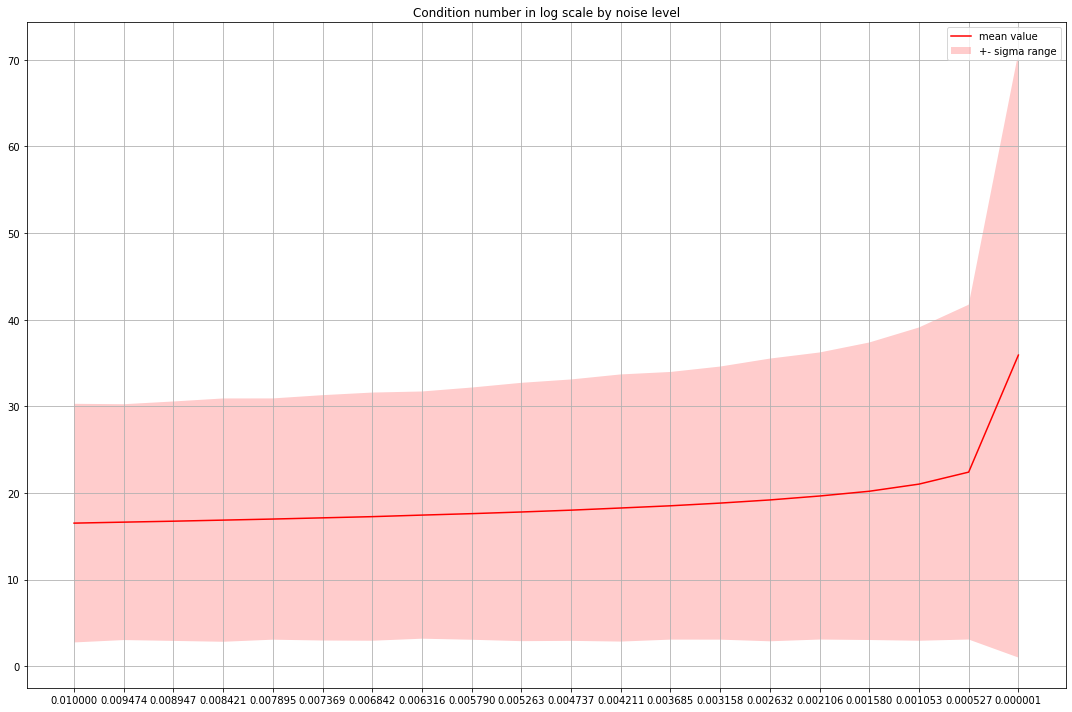

In [258]:
visualise(
    np.log(condition_numbers[:, 0]),
    np.log(condition_numbers[:, 1]),
    np.arange(len(noise_eps_seq)),
    ['{0:.6f}'.format(x) for x in noise_eps_seq],
    title='Condition number in log scale by noise level',
    greater_than_zero=True,
)

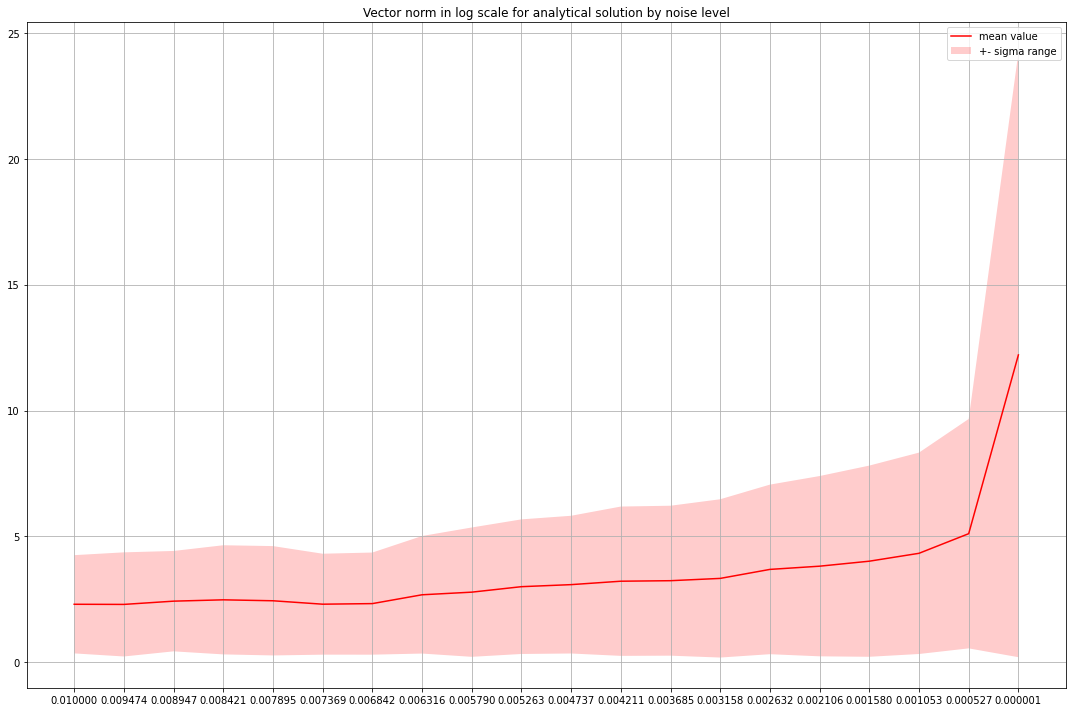

In [259]:
visualise(
    np.log(vector_norms_list[:, 0, 0]),
    np.log(vector_norms_list[:, 1, 0]),
    np.arange(len(noise_eps_seq)),
    ['{0:.6f}'.format(x) for x in noise_eps_seq],
    title='Vector norm in log scale for analytical solution by noise level',
    greater_than_zero=True,
)

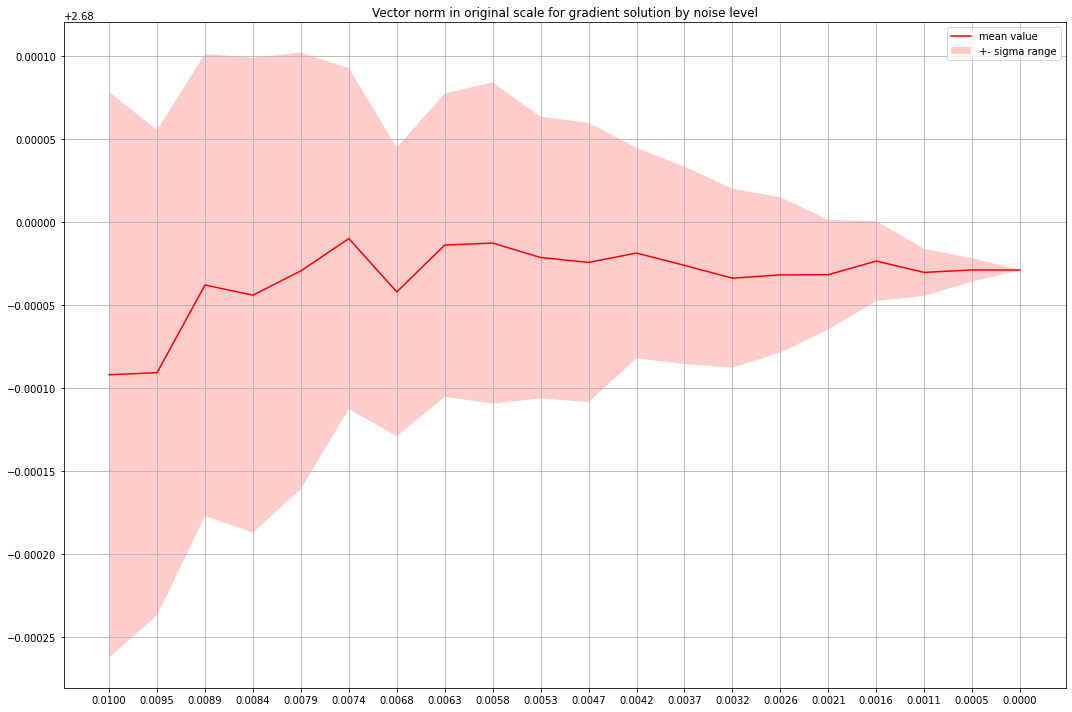

In [260]:
visualise(
    vector_norms_list[:, 0, 1],
    vector_norms_list[:, 1, 1],
    np.arange(len(noise_eps_seq)),
    ['{0:.4f}'.format(x) for x in noise_eps_seq],
    title='Vector norm in original scale for gradient solution by noise level',
    greater_than_zero=True,
)

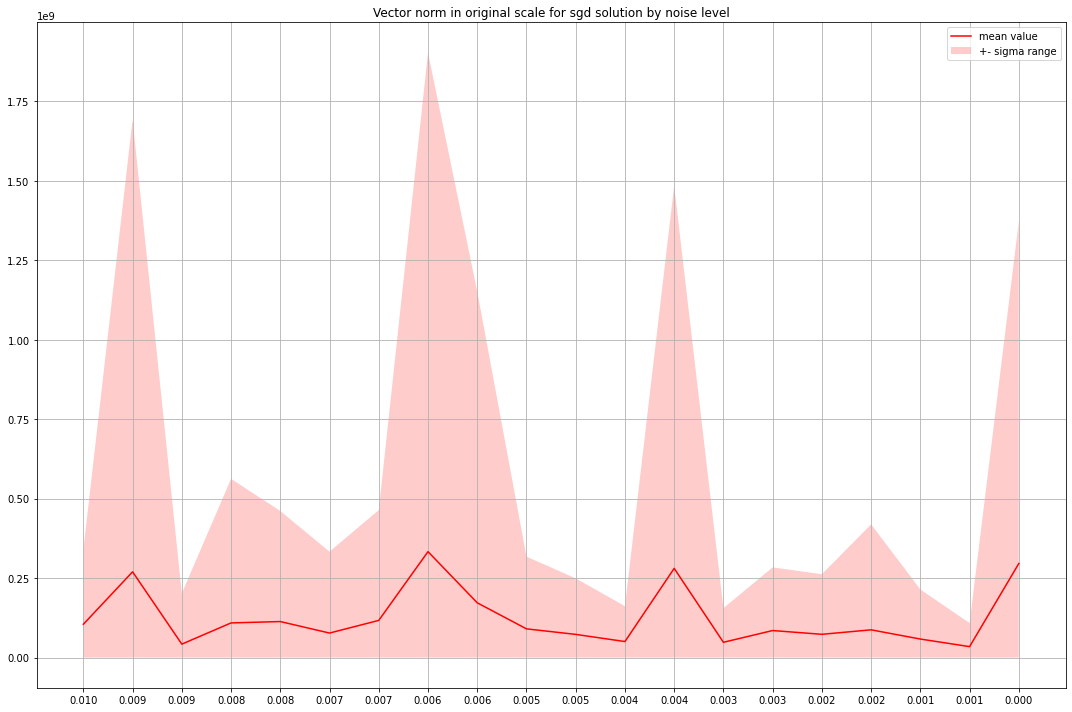

In [261]:
visualise(
    vector_norms_list[:, 0, 2],
    vector_norms_list[:, 1, 2],
    np.arange(len(noise_eps_seq)),
    ['{0:.3f}'.format(x) for x in noise_eps_seq],
    title='Vector norm in original scale for sgd solution by noise level',
    greater_than_zero=True,
)

##  Вероятностный взгляд на линейную регрессию
Вероятностный подход дает красивую статистическую интерпретацию различных функций потерь и регуляризации.

### Вероятностный взгляд на функции потерь

В вероятностном подходе к машинному обучению все сущности (объекты, целевые переменные, параметры моделей) рассматриваются как случайные величины. Задача ставится следующим образом: надо найти распределение на эти случайные величины, которое лучше всего описывает данные (множество пар объект $-$ целевой признак). Это распределение будет описывать процесс порождения наших данных (рассмотрим далее на прмиерах). На этом семинаре мы будем рассматривать дискриминативные модели, в которых предсказывается распределение на целевую переменную при заданном объекте: $p(y_i|x_i, \theta)$, $\theta$ — параметры модели. Другой подход — это моделировать совместное распределение $p(y_i, x_i|\theta)$ (генеративная модель).

Для настройки параметров в вероятностном подходе часто применяют метод максимального правдоподобия, известный вам из курса математической статистики. В нем правдоподобие вероятностной модели:
$$p(y|X, \theta) = \prod_i p(y_i|x_i, \theta)$$
логарифмируется и оптимизируется по параметрам модели:
$$\log p(y|X, \theta) = \sum_i \log p(y_i|x_i, \theta) \rightarrow \max_{\theta}.$$

До этого момента мы рассматривали только точечные предсказания: $y_i = w^T x_i$. Когда мы начинаем рассматривать $y_i$ как случайную величину, мы как бы признаем неточность этого предсказания и допускаем, что можем ошибиться. Логично взять распределение $p(y_i|x_i, \theta)$, имеющее моду в $y = w^T x$ и монотонно убывающее слева и справа от нее. Для начала возьмем нормальное распределение:
$$p(y_i|x_i, \theta) = \mathcal{N}(y_i|x_i^T w, \sigma^2).$$
Здесь мы обозначили $\theta=\{w, \sigma\}$ — множество параметров вероятностной модели. Процесс порождения данных в этом случае предельно простой: мы предполагаем, что $y_i$ случайно сгенерировано из $\mathcal{N}(y_i|x_i^T w, \sigma^2)$.

__Задача.__ Найдите, какой функции потерь соответствует метод максимального правдоподобия для данной модели.

_Решение._ Преобразуем логарифм правдоподобия:
$$\log p(y|X, \theta) = \sum_i \log \mathcal{N}(y_i|x_i^T w, \sigma^2) = $$
$$=\sum_i \log \biggl( \frac{1}{\sqrt{2\pi}\sigma}exp\bigl(-\frac {(y_i - w^T x_i)^2} {2 \sigma^2}  \bigr)\biggr)=$$
$$=\sum_i \biggl( -0.5 \log(2\pi) - \log \sigma  -\frac {(y_i - w^T x_i)^2} {2 \sigma^2} \biggr) = $$
$$=C - \frac 1 {2 \sigma^2} \sum_i (y_i - w^T x_i)^2 \rightarrow \max_{w}, \quad C = -\frac \ell 2 \log(2\pi)  $$
Константы $C$, $\sigma$ не влияют на точку оптимума, а знак минус можно удалить, заменив задачу макисимзации на задачу минимизации, поэтому в итоге мы получаем слудеющую оптимизационную задачу:
$$ \sum_i (y_i - w^T x_i)^2 \rightarrow \min_w $$
Мы видим, что применение метода максимального правдоподобия к нашей задаче равносильно оптимизации MSE, что соответствует квадратичной функции потерь. 

Итак, вероятностный подход дает следующую интерпретацию квадратичной функции потерь для линейных моделей: при ее применении мы предполагаем, что (а) зависимость целевой переменной от признаков линейна и (б) ошибки предсказаний линейной модели распределены нормально. На практике последнее условие можно попробовать проверить графически, а именно: построить гистограмму ошибок и оценить ее нормальность. Конечно, в статистике существуют специальные тесты для проверки нормальности, но мы не будем их затрагивать. 

Пример гистограммы ошибок на наших данных:

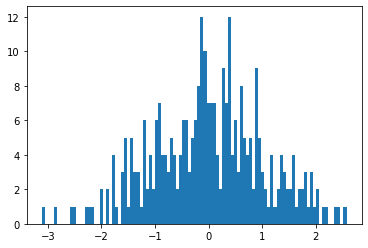

In [264]:
lr = LR()
lr.fit(X, Y)
pr = lr.predict(X)
retval = plt.hist(pr - Y, 100)

Аналогично можно провести анализ, если вместо нормального распределения взять, к примеру, распределение Лапласа:
$$p(y_i|x_i, \theta=\{w, \alpha\}) = \frac \alpha 2 \exp \bigl( -\alpha \bigl|y_i - w^Tx_i\bigr| \bigr).$$
Для этой модели метод максимального правдоподобия соответствует оптимизации MAE.

### Вероятностный взгляд на регуляризацию
Во всех предыдущих рассуждениях мы рассматривали только целевую переменную как случайную величину, а признаки объекта и веса считали фиксированным векторамию. Мы можем несколько усложнить нашу вероятностную модель и считать, что веса модели — тоже случайная величина. Здесь мы придем к понятию априорного распределения $p(w)$: это распределение на веса линейной модели, отображающее наше представление о них до того, как к нам поступили данные. Модель порождения данных тогда будет выглядеть так:
1. Сгенерировать вектор весов $w \sim p(w)$;
1. Для всех объектов сгенерировать $y_i \sim p(y_i|x_i, \theta=\{w, \dots\})$.
Вероятностная модель:
$$p(y, w|X) = \bigl [ \prod_i p(y_i|x_i, \theta) \bigr ] p(w). $$

Когда мы получили данные, мы можем искать наиболее вероятное значение весов — моду апостериорного распределения $p(w|X, y)$.

__Задача.__ Какому критерию качества соответствует поиск моды апостериорного распределения, если $p(w)=\mathcal{N}(w|0, I)$ — стандартное многомерное нормальное распределение?

_Решение._
Найдем моду распределения. По формуле Байеса:
$$p(w|X,y) = \frac {p(y|X, w)p(w)}{p(y|X)} = \frac {\prod_i p(y_i|x_i, w) p(w)}{p(y|X)} $$
Знаменатель не зависит от $w$ и не повлияет на точку моды распределения, поэтому не будем далее его рассматривать. Прологарифмируем числитель:
$$\sum_i \log p(y_i|x_i, w) + \log p(w) \rightarrow \max_{w}$$
Первое слагаемое мы уже вычисляли ранее, оно соответствует среднеквадратичному отклонению. Займемся вторым слагаемым:
$$\log p(w) = \log \mathcal{N}(w|0, I) = \log \biggl( \frac{1}{\sqrt{2\pi}^d }exp\bigl(-\frac {w^T w} {2 }  \bigr)\biggr) =$$
$$- \frac d 2 \log \pi  -\frac {w^T w} {2 } .$$
Первое слагаемое — константа, не влияющая на точку минимума, второе слагаемое — евклидова норма весов. Итак, мы получили следующий оптимизируемый критерий:
$$- \frac 1 {2 \sigma^2}\sum_i (y_i - w^T x_i)^2 + \frac 1 2 w^Tw \rightarrow \min_w$$
Это в точности соответствует $L_2$-регуляризованной линейной регрессии. Обратите внимание, что здесь мы уже не можем опустить множитель $\frac 1 {2 \sigma^2}$. Семантически он соответствует коэффициенту регуляризации и настраивает баланс между оптимизацией качества решения задачи и регуляризатором.

Аналогично можно рассмотреть, к примеру, априорное распределение Лапласа и получить, что оно соответствует $L_1$-регуляризации в линейной регрессии.

Напоследок (в этой секции) отметим, что все приведенные рассуждения можно повторить для любых алгоритмов машинного обучения, заменив $w^Tx$ на другую модель зависимости.
